In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyboardInterrupt: 

In [ ]:
import torch
import pathlib
import numpy as np
import pandas as pd

seed_ = 42

dim = 16
directory = pathlib.Path("../events/MG3")

df_3b = pd.read_hdf(directory / "dataframes" / "symmetrized_bbbj.h5")
df_bg4b = pd.read_hdf(directory / "dataframes" / "symmetrized_bbbb_large.h5")
df_hh4b = pd.read_hdf(directory / "dataframes" / "symmetrized_HH4b.h5")

df_3b["signal"] = False
df_bg4b["signal"] = False
df_hh4b["signal"] = True

print("3b-jet events: ", len(df_3b))
print("4b-jet events: ", len(df_bg4b))
print("HH4b-jet events: ", len(df_hh4b))

# shuffle the data
df_3b = df_3b.sample(frac=1, random_state=seed_).reset_index(drop=True)
df_bg4b = df_bg4b.sample(frac=1, random_state=seed_).reset_index(drop=True)
df_hh4b = df_hh4b.sample(frac=1, random_state=seed_).reset_index(drop=True)

3b-jet events:  275508
4b-jet events:  382108
HH4b-jet events:  28656


Seed set to 42


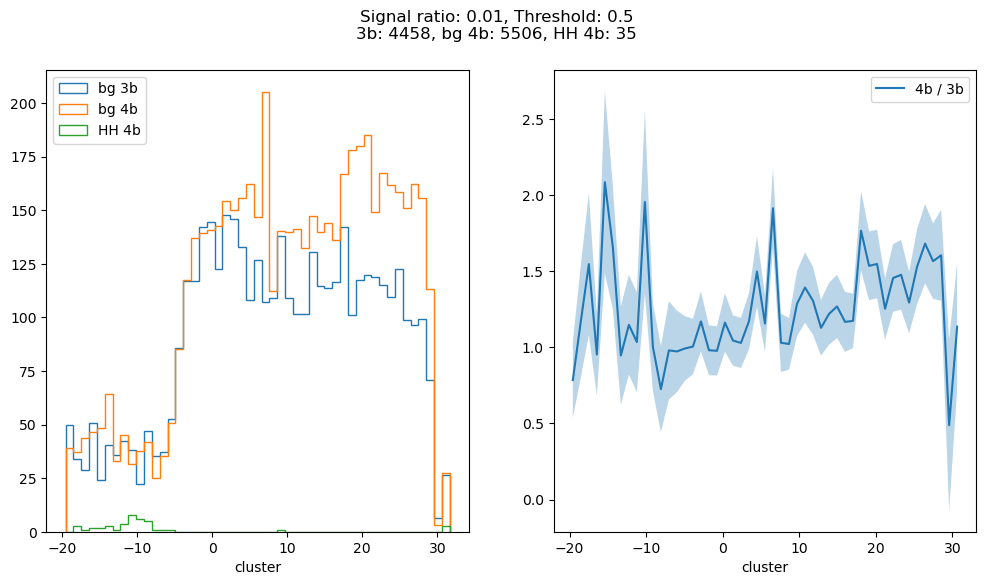

/home/soheuny/HH4bsim/playground/plots.py:329: RuntimeWarning:

divide by zero encountered in divide

/home/soheuny/HH4bsim/playground/plots.py:329: RuntimeWarning:

invalid value encountered in divide

/home/soheuny/HH4bsim/playground/plots.py:330: RuntimeWarning:

divide by zero encountered in divide

/home/soheuny/HH4bsim/playground/plots.py:330: RuntimeWarning:

invalid value encountered in multiply

/home/soheuny/HH4bsim/playground/plots.py:330: RuntimeWarning:

invalid value encountered in divide

/home/soheuny/HH4bsim/playground/plots.py:333: RuntimeWarning:

invalid value encountered in subtract



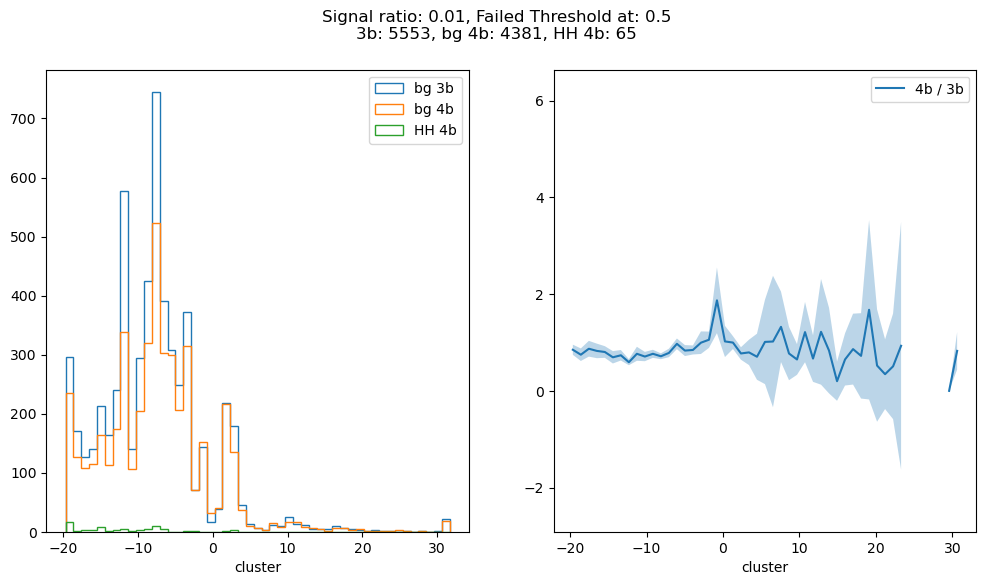

/home/soheuny/HH4bsim/playground/plots.py:329: RuntimeWarning:

divide by zero encountered in divide

/home/soheuny/HH4bsim/playground/plots.py:330: RuntimeWarning:

divide by zero encountered in divide

/home/soheuny/HH4bsim/playground/plots.py:333: RuntimeWarning:

invalid value encountered in subtract



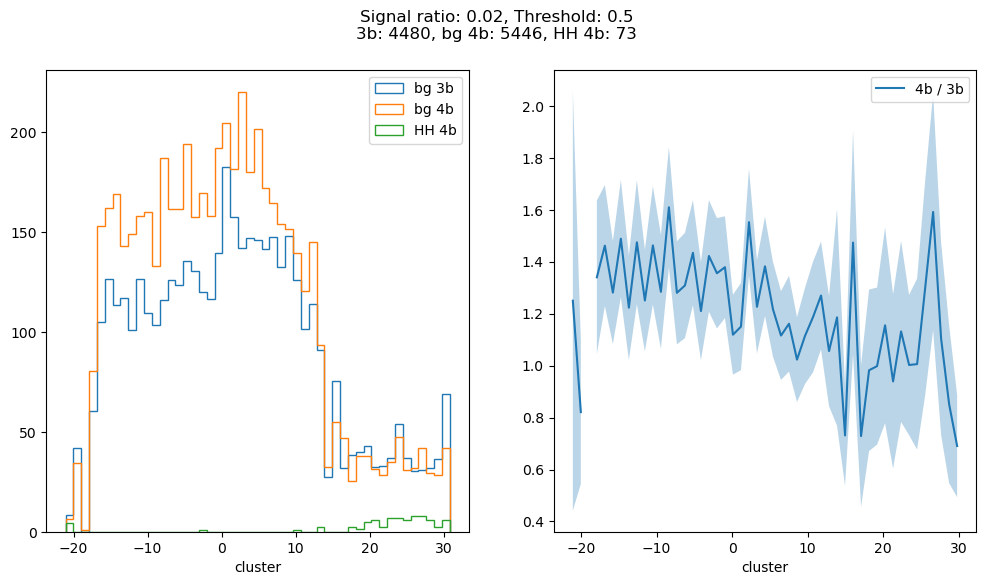

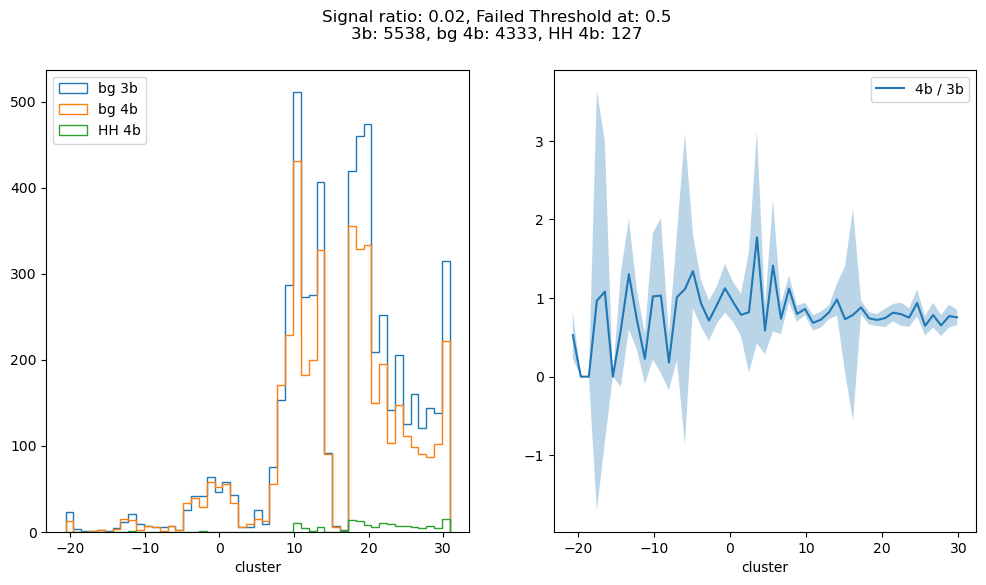

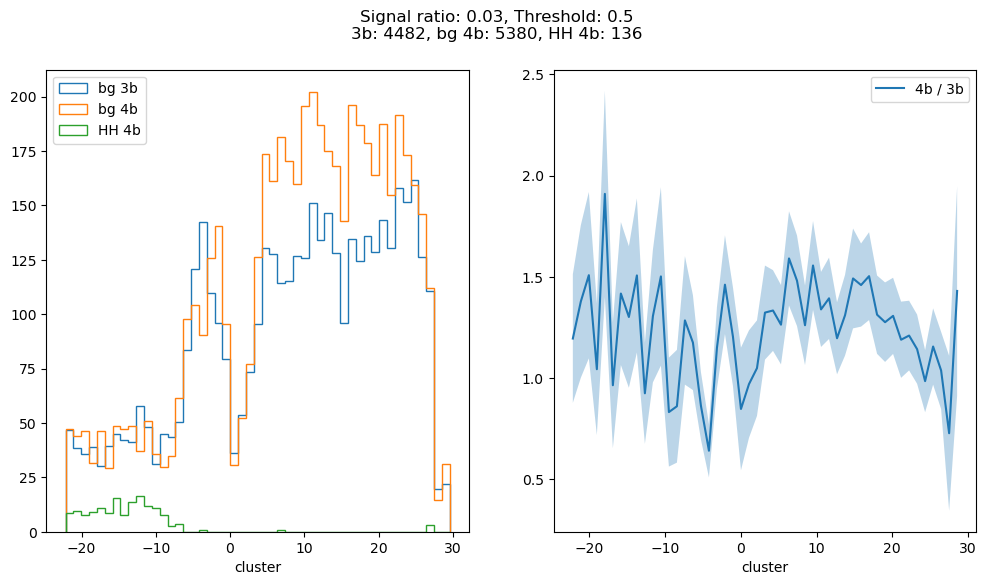

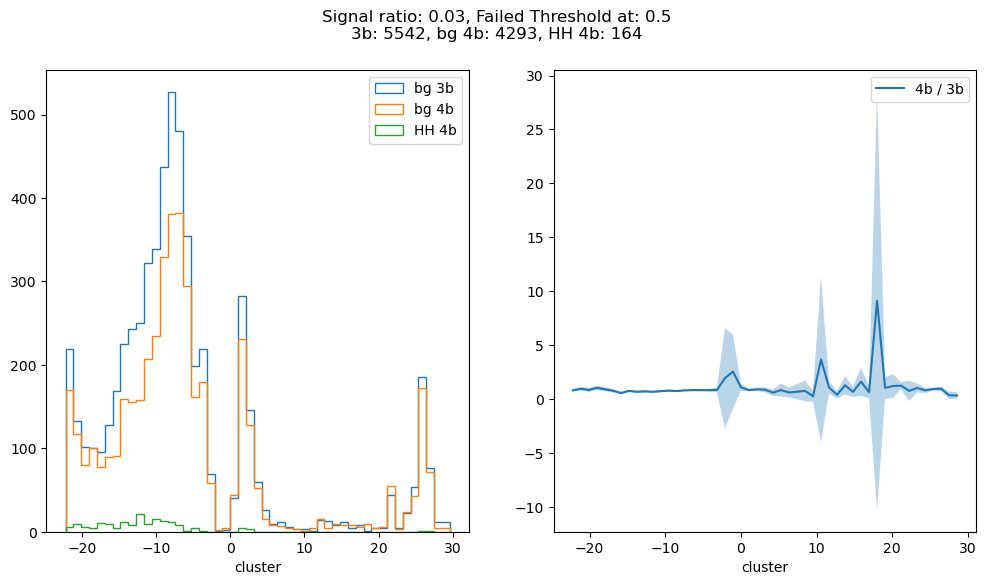

In [28]:
import pytorch_lightning as pl
from torch.utils.data import TensorDataset
from fvt_classifier import FvTClassifier
from fvt_representations import get_fvt_reprs


np.random.seed(seed_)

features = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
            "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
            "sym_canJet0_phi", "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
            "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]

pl.seed_everything(seed_)
np.random.seed(seed_)

test_ratio = 0.5
n_3b = 250000
n_all4b = 250000
# signal_ratio = 0.05

for signal_ratio in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]:

    # print(f"Signal ratio: {signal_ratio}")


    n_3b_train = int(n_3b * (1 - test_ratio))
    n_all4b_train = int(n_all4b * (1 - test_ratio))
    n_bg4b_train = n_all4b_train - int(n_all4b_train * signal_ratio)
    n_hh4b_train = int(n_all4b_train * signal_ratio)


    df_3b_train = df_3b.iloc[:n_3b_train]
    df_bg4b_train = df_bg4b.iloc[:n_bg4b_train]
    df_hh4b_train = df_hh4b.iloc[:n_hh4b_train]
    # reweight to match signal_ratio
    df_hh4b_train.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                                np.sum(df_bg4b_train["weight"]) / np.sum(df_hh4b_train["weight"])) * df_hh4b_train["weight"]
    df_train = pd.concat([df_3b_train, df_bg4b_train, df_hh4b_train])
    # shuffle the data
    df_train = df_train.sample(frac=1, random_state=seed_).reset_index(drop=True)

    n_3b_test = n_3b - n_3b_train
    n_all4b_test = n_all4b - n_all4b_train
    n_bg4b_test = n_all4b_test - int(n_all4b_test * signal_ratio)
    n_hh4b_test = int(n_all4b_test * signal_ratio)

    df_3b_test = df_3b.iloc[n_3b_train:n_3b_train+n_3b_test]
    df_bg4b_test = df_bg4b.iloc[n_bg4b_train:n_bg4b_train+n_bg4b_test]
    df_hh4b_test = df_hh4b.iloc[n_hh4b_train:n_hh4b_train+n_hh4b_test]
    df_hh4b_test.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                                np.sum(df_bg4b_test["weight"]) / np.sum(df_hh4b_test["weight"])) * df_hh4b_test["weight"]
    df_test = pd.concat([df_3b_test, df_bg4b_test, df_hh4b_test])
    df_test = df_test.sample(frac=1, random_state=seed_).reset_index(drop=True)

    # reduce number of 4b samples to 1/8
    # print("4b ratio: ", df_train.loc[df_train["fourTag"], "weight"].sum() / df_train["weight"].sum())
    # print("Signal ratio: ", df_train.loc[df_train["signal"], "weight"].sum() / df_train.loc[df_train["fourTag"], "weight"].sum())

    # For ghostbatch, let len(train_indices) be a multiple of 32
    split_at = 1024 * (int((2/3) * df_train.index.size) // 1024)
    end_at = 1024 * (df_train.index.size // 1024)

    X_train = torch.tensor(df_train[features].values, dtype=torch.float32)[:split_at]
    w_train = torch.tensor(df_train["weight"].values, dtype=torch.float32)[:split_at]
    y_train = torch.tensor(df_train["fourTag"].values, dtype=torch.long)[:split_at]
    is_signal_train = torch.tensor(df_train["signal"].values, dtype=torch.long)[:split_at]

    X_val = torch.tensor(df_train[features].values, dtype=torch.float32)[split_at:end_at]
    w_val = torch.tensor(df_train["weight"].values, dtype=torch.float32)[split_at:end_at]
    y_val = torch.tensor(df_train["fourTag"].values, dtype=torch.long)[split_at:end_at]
    is_signal_val = torch.tensor(df_train["signal"].values, dtype=torch.long)[split_at:end_at]

    train_dataset = TensorDataset(X_train, y_train, w_train)
    val_dataset = TensorDataset(X_val, y_val, w_val)


    num_classes = 2
    dim_input_jet_features = 4
    dim_dijet_features = 6
    dim_quadjet_features = 6
    max_epochs = 30
    run_name = "_".join(["fvt_classifier_toy_signal_ratio", 
                        f"signal_ratio={signal_ratio}", 
                        f"dijet={dim_dijet_features}", 
                        f"quadjet={dim_quadjet_features}", 
                        f"n_3b={n_3b}",
                        f"n_all4b={n_all4b}",])
    lr = 1e-3



    end_at = 1024 * (df_test.index.size // 1024)

    X_test = torch.tensor(df_test[features].values[:end_at], dtype=torch.float32)
    w_test = torch.tensor(df_test["weight"].values[:end_at], dtype=torch.float32)
    y_test = torch.tensor(df_test["fourTag"].values[:end_at], dtype=torch.long)
    is_signal_test = torch.tensor(df_test["signal"].values[:end_at], dtype=torch.long)

    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
    q_repr_test, view_scores_test = get_fvt_reprs(X_test, fvt_model)
    labels_4b_test = y_test.cpu().numpy()
    probs_4b_test = fvt_model.predict(X_test)[:, 1].cpu().numpy()
    weights_test = w_test.cpu().numpy()
    is_signal_test = is_signal_test.cpu().numpy()
    is_3b_test = labels_4b_test == 0
    is_4b_test = labels_4b_test == 1
    is_bg4b_test = (labels_4b_test == 1) & (is_signal_test == 0)
    is_hh4b_test = (labels_4b_test == 1) & (is_signal_test == 1)

    # umap
    from plots import plot_cluster
    import umap

    n_components = 1
    umap_reducer = umap.UMAP(n_components=n_components, 
                            #  random_state=seed_, 
                             verbose=False)
    reducer = umap_reducer
    
    # probs_4b_threshold = 0.6

    # for probs_4b_threshold in [0.4, 0.5, 0.6]:
    for probs_4b_threshold in [0.5]:
        # print(f"Threshold: {probs_4b_threshold}")

        probs_4b_exceeded = probs_4b_test > probs_4b_threshold
        n_exceeded = np.sum(probs_4b_exceeded)

        n_points = min(np.sum(probs_4b_exceeded), 10000)
        n_cluster_3b = np.sum(is_3b_test & probs_4b_exceeded)
        n_cluster_bg4b = np.sum(is_bg4b_test & probs_4b_exceeded)
        n_cluster_hh4b = np.sum(is_hh4b_test & probs_4b_exceeded)

        n_cluster_3b = int((n_points / n_exceeded) * n_cluster_3b)
        n_cluster_bg4b = int((n_points / n_exceeded) * n_cluster_bg4b)
        n_cluster_hh4b = int((n_points / n_exceeded) * n_cluster_hh4b)

        np.random.seed(seed_)
        # cluster_samples = np.random.choice(np.where(probs_4b_exceeded)[0], n_points, replace=False)
        # cluster_samples = np.random.choice(np.where(~probs_4b_exceeded)[0], n_points, replace=False)
        # cluster_samples = np.random.choice(np.where(probs_4b_exceeded & (~is_signal_test))[0], n_points, replace=False)

        cluster_samples = np.concatenate([
            np.random.choice(np.where(is_3b_test & probs_4b_exceeded)[0], n_cluster_3b, replace=False),
            np.random.choice(np.where(is_bg4b_test & probs_4b_exceeded)[0], n_cluster_bg4b, replace=False),
            np.random.choice(np.where(is_hh4b_test & probs_4b_exceeded)[0], n_cluster_hh4b, replace=False),
        ])
        q_repr_cluster = q_repr_test[cluster_samples]
        is_3b_cluster = labels_4b_test[cluster_samples] == 0
        is_bg4b_cluster = (labels_4b_test[cluster_samples] == 1) & (is_signal_test[cluster_samples] == 0)
        is_hh4b_cluster = is_signal_test[cluster_samples] == 1
        weights_cluster = weights_test[cluster_samples]
        view_scores_cluster = view_scores_test[cluster_samples]

        # print number of points in each class
        # print("Thresholded samples")
        # print("3b: ", np.sum(is_3b_cluster))
        # print("bg4b: ", np.sum(is_bg4b_cluster))
        # print("hh4b: ", np.sum(is_hh4b_cluster))

        # cluster_repr_test = umap_reducer.fit_transform(q_repr_cluster.reshape(-1, 3*dim_quadjet_features))

        # plot_cluster(cluster_repr_test, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components)

        att_q_repr_cluster = (q_repr_cluster @ view_scores_cluster[:, :, None]).reshape(-1, dim_quadjet_features)
        cluster_repr_test = reducer.fit_transform(att_q_repr_cluster)

        plot_cluster(cluster_repr_test, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components, 
                     title=f"Signal ratio: {signal_ratio}, Threshold: {probs_4b_threshold}")


        # # failed samples
        # print("Failed samples")
        # print("3b: ", np.sum(is_3b_test & ~probs_4b_exceeded))
        # print("bg4b: ", np.sum(is_bg4b_test & ~probs_4b_exceeded))
        # print("hh4b: ", np.sum(is_hh4b_test & ~probs_4b_exceeded))

        n_failed = np.sum(~probs_4b_exceeded)
        n_points = min(np.sum(~probs_4b_exceeded), 10000)
        n_failed_3b = np.sum(is_3b_test & ~probs_4b_exceeded)
        n_failed_bg4b = np.sum(is_bg4b_test & ~probs_4b_exceeded)
        n_failed_hh4b = np.sum(is_hh4b_test & ~probs_4b_exceeded)

        n_failed_3b = int((n_points / n_failed) * n_failed_3b)
        n_failed_bg4b = int((n_points / n_failed) * n_failed_bg4b)
        n_failed_hh4b = int((n_points / n_failed) * n_failed_hh4b)

        thrs_fail_samples = np.concatenate([
            np.random.choice(np.where(is_3b_test & ~probs_4b_exceeded)[0], n_failed_3b, replace=False),
            np.random.choice(np.where(is_bg4b_test & ~probs_4b_exceeded)[0], n_failed_bg4b, replace=False),
            np.random.choice(np.where(is_hh4b_test & ~probs_4b_exceeded)[0], n_failed_hh4b, replace=False),
        ])

        q_repr_fail = q_repr_test[thrs_fail_samples]
        is_3b_fail = labels_4b_test[thrs_fail_samples] == 0
        is_bg4b_fail = (labels_4b_test[thrs_fail_samples] == 1) & (is_signal_test[thrs_fail_samples] == 0)
        is_hh4b_fail = is_signal_test[thrs_fail_samples] == 1
        weights_fail = weights_test[thrs_fail_samples]
        view_scores_fail = view_scores_test[thrs_fail_samples]

        att_q_repr_fail = (q_repr_fail @ view_scores_fail[:, :, None]).reshape(-1, dim_quadjet_features)
        cluster_repr_fail = reducer.transform(att_q_repr_fail)

        plot_cluster(cluster_repr_fail, is_3b_fail, is_bg4b_fail, is_hh4b_fail, weights_fail, 
                     n_components=n_components, title=f"Signal ratio: {signal_ratio}, Failed Threshold at: {probs_4b_threshold}")

        # # randomly choose 30000 points
        # att_q_repr_test = (q_repr_test @ view_scores_test[:, :, None]).reshape(-1, dim_quadjet_features)

        # random_idx = np.random.choice(att_q_repr_test.shape[0], 30000, replace=False)
        # umap_embed_test_sample = umap_reducer.transform(att_q_repr_test[random_idx])

        # plot_cluster(umap_embed_test_sample, is_3b_test[random_idx], is_bg4b_test[random_idx], is_hh4b_test[random_idx], weights_test[random_idx], 
        #              n_components=n_components, title=f"Signal ratio: {signal_ratio}, Randomly chosen 30000 points")